In [1]:
import os
import io
import numpy as np
from PIL import Image
import fitz
import re
import torch
import math
import time

from faster_rcnn import FasterRCNN, to_tensor, BradOCR, plot_text_xyxy
from yolov3 import load_model, batch_extract_bboxes_from_BRAD_OCR_images
from ocr_post_process import group_text_into_line, find_single_passage

nt
nt


In [2]:
class BradOCRv2:
    def __init__(
            self, 
            filepath_model_word=None, n_test_pre_nms_WORD=12000, n_test_post_nms_WORD=2000,
            filepath_model_char=None, fix_img_H=64,
            label_names_char = list('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ~!@#$%^&*()_+-={}|[]\:";'<>?,./'''), # full except: `
            ):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        #--- load models ----------------------------------
        reloaded_word = torch.load(filepath_model_word, map_location=torch.device(device))
        reloaded_word['model_init_inputs']['n_test_pre_nms'] = n_test_pre_nms_WORD # modify model inputs
        reloaded_word['model_init_inputs']['n_test_post_nms'] = n_test_post_nms_WORD # modify model inputs
        print(f">> reloaded_word['model_init_inputs'] = {reloaded_word['model_init_inputs']}")

        #--- load model ----------------------------------
        self.models = {}

        self.models['word'] = FasterRCNN(**reloaded_word['model_init_inputs'])
        self.models['word'].load_state_dict(reloaded_word['model']) # full except: `

        self.models['char'] = load_model(None, n_classes=len(label_names_char), weights_path=filepath_model_char)
        self.fix_img_H = fix_img_H
        self.label_names_char = label_names_char

    def predict(self, img, fix_img_H=None, conf_thres=0.5, iou_thres=0.5, max_wh=0, verbose=False, draw_bboxes=False, debug=False):
        if fix_img_H is None:
            fix_img_H = self.fix_img_H
        #--- predict words -----------------------------------------------------------------
        tic = time.time()
        pred_bboxes, pred_labels, pred_scores = self.models['word'].predict(to_tensor(img[None]), visualize=True) # Brad decision 7/6/2024
        toc = time.time()
        if verbose:
            print(f'> word prediction time: {round(toc - tic,2)} [sec]')

        #--- predict characters -----------------------------------------------------------
        imgs, x0y0s = [], []
        for y0, x0, y1, x1 in pred_bboxes[0]:
            y0, x0, y1, x1 = math.floor(y0), math.floor(x0), math.ceil(y1), math.ceil(x1)

            img_text = img[y0:(y1+1), x0:(x1+1), :].copy() # crop image to extract target text

            imgs.append(img_text)
            x0y0s.append((x0, y0))

        tic = time.time()
        detections_rescaled = batch_extract_bboxes_from_BRAD_OCR_images(self.models['char'], self.label_names_char, imgs, fix_img_H, x0y0s=x0y0s, conf_thres=conf_thres, iou_thres=iou_thres, max_wh=max_wh, draw_bboxes=draw_bboxes)
        toc = time.time()
        if verbose:
            print(f'> character prediction time: {round(toc - tic,2)} [sec]')

        pred_texts = []
        for (y0, x0, y1, x1), detection_rescaled in zip(pred_bboxes[0], detections_rescaled):

            pred_texts.append((
                ''.join(label for x1, y1, x2, y2, conf, label in detection_rescaled),
                (x0, y0, x1, y1),
                ))

        return {
            'pred_texts':pred_texts,
        }

- load model

In [3]:
# ocr_model = BradOCR(
#     filepath_model_word=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\word\fasterrcnn_01010320_0.9651181492864416'), # resnet
#     filepath_model_char=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\char\fasterrcnn_01270246_0.9668653988020294'),  # pjt_faster_rcnn_250126_OCR_CHAR3_0p5 vgg
#     n_test_pre_nms_WORD=12000, n_test_post_nms_WORD=2000,
#     n_test_pre_nms_CHAR=600, n_test_post_nms_CHAR=100,
#     label_names_char = list('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ~!@#$%^&*()_+-={}|[]\:";'<>?,./'''), # full except: `
# )

In [4]:
ocr_model = BradOCRv2(
    filepath_model_word=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\word\fasterrcnn_01010320_0.9651181492864416'), # resnet
    n_test_pre_nms_WORD=12000, n_test_post_nms_WORD=2000,

    filepath_model_char=os.path.join(r'C:\Users\bomso\bomsoo1\python\GitHub\_model_trained\yolov3\yolov3_ckpt_20250528_1913_100_H32_n20000.pth'), fix_img_H=32,  # yolov3
    # filepath_model_char=os.path.join(r'C:\Users\bomso\bomsoo1\python\GitHub\_model_trained\yolov3\yolov3_ckpt_20250527_1537_80_H64_n5000.pth'), fix_img_H=64,  # yolov3
    label_names_char = list('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ~!@#$%^&*()_+-={}|[]\:";'<>?,./'''), # full except: `
)

>> reloaded_word['model_init_inputs'] = {'n_fg_class': 1, 'feat_stride': 16, 'loc_normalize_mean': (0.0, 0.0, 0.0, 0.0), 'loc_normalize_std': (0.1, 0.1, 0.2, 0.2), 'backbone_name': 'resnet101', 'use_pretrained_weights': True, 'freeze_param_up_to': 0, 'ceil_mode_for_MaxPool2d': True, 'always_freeze_first_batch_norm': False, 'use_untrained_vgg_classifier': False, 'base_size': 16, 'ratios': [0.25, 0.5, 1, 2, 4], 'anchor_scales': [0.25, 0.5, 1, 2, 4], 'y_offsets': [0], 'x_offsets': [0], 'nms_thresh': 0.7, 'n_train_pre_nms': 12000, 'n_train_post_nms': 2000, 'n_test_pre_nms': 12000, 'n_test_post_nms': 2000, 'min_size': 0, 'roi_size': 7, 'is_roi_align': True, 'roi_align_sampling_ratio': 2, 'roi_align_aligned': True}
> No model config file is specified. So, the default configuration for yolo v3 is applied. check "CONFIG_LINES_FOR_YOLO_V3" inside the code.


- load image / detect text

> word prediction time: 7.17 [sec]
> character prediction time: 0.48 [sec]


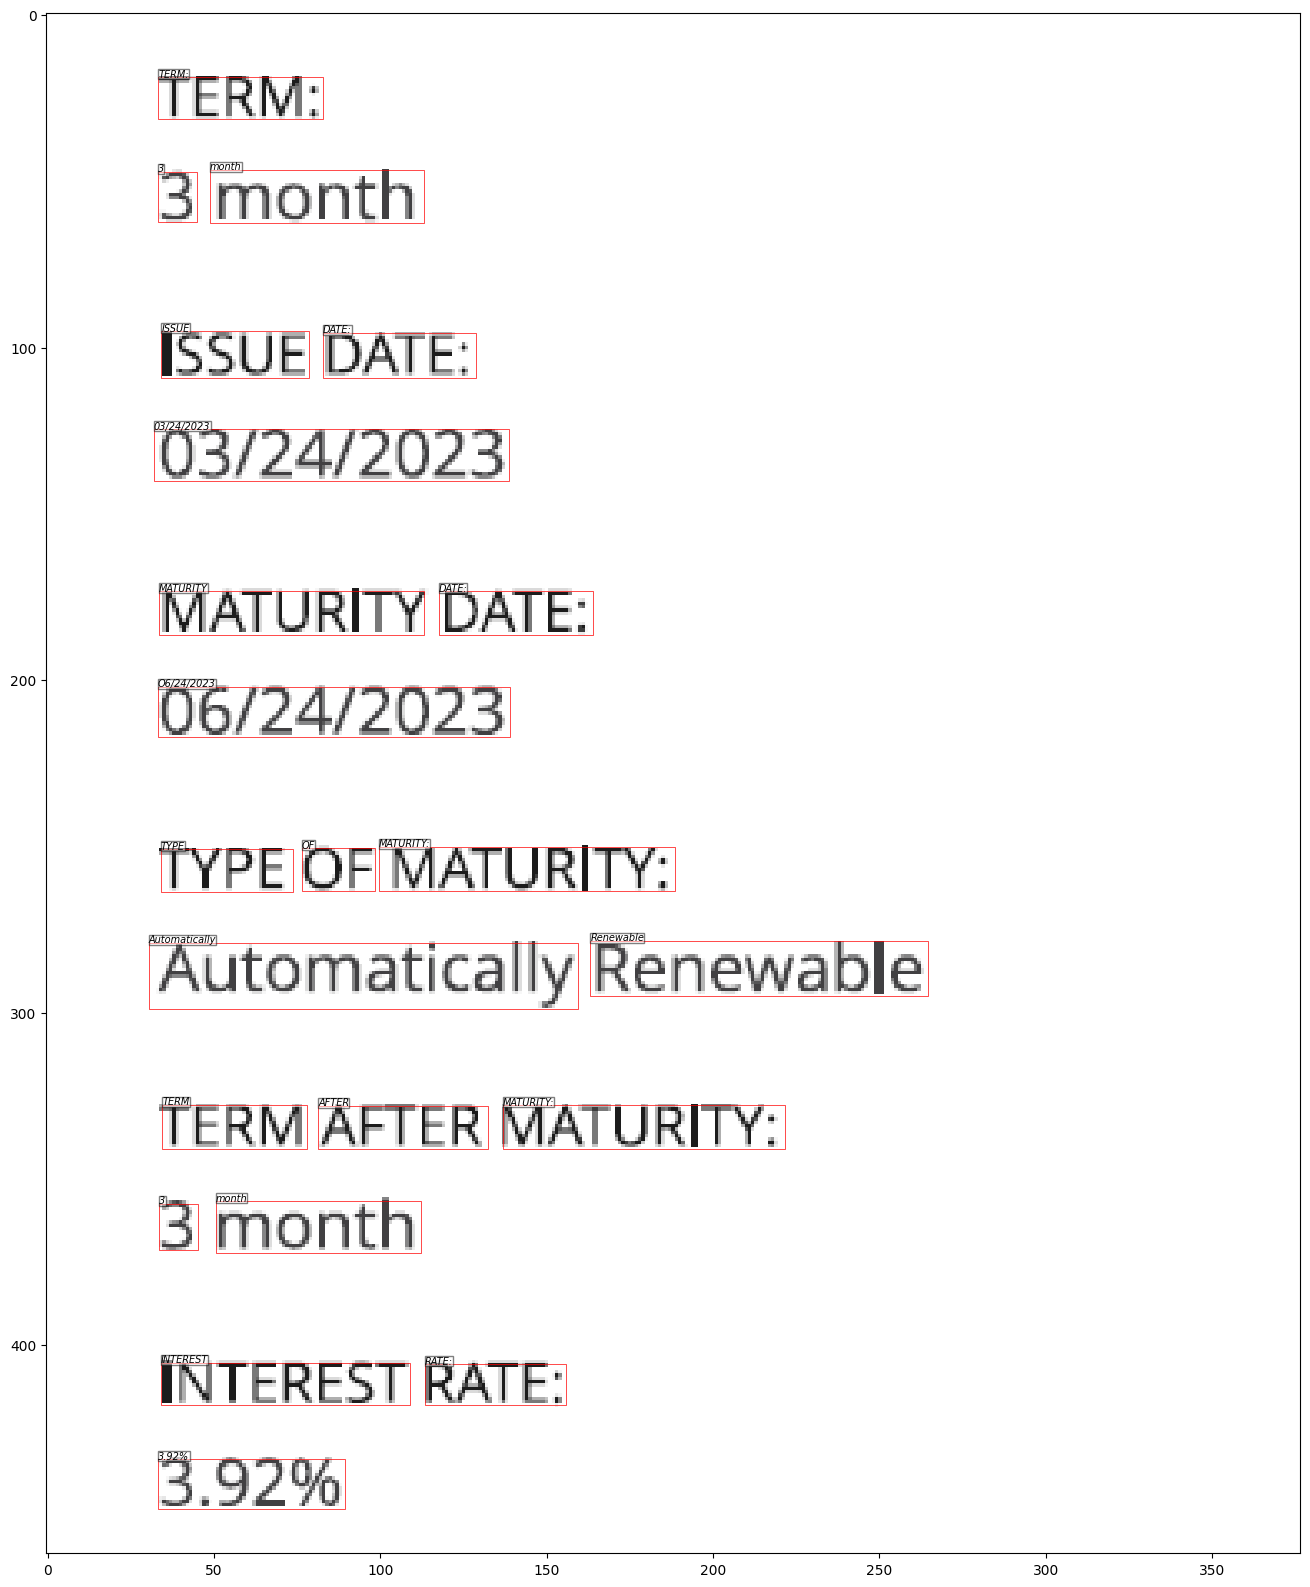

TERM:
3 month
ISSUE DATE:
03/24/2023
MATURITY DATE:
O6/24/2023
TYPE OF MATURITY:
Automatically Renewable
TERM AFTER MATURITY:
3 month
INTEREST RATE:
3.92%
> word prediction time: 7.95 [sec]
> character prediction time: 1.77 [sec]


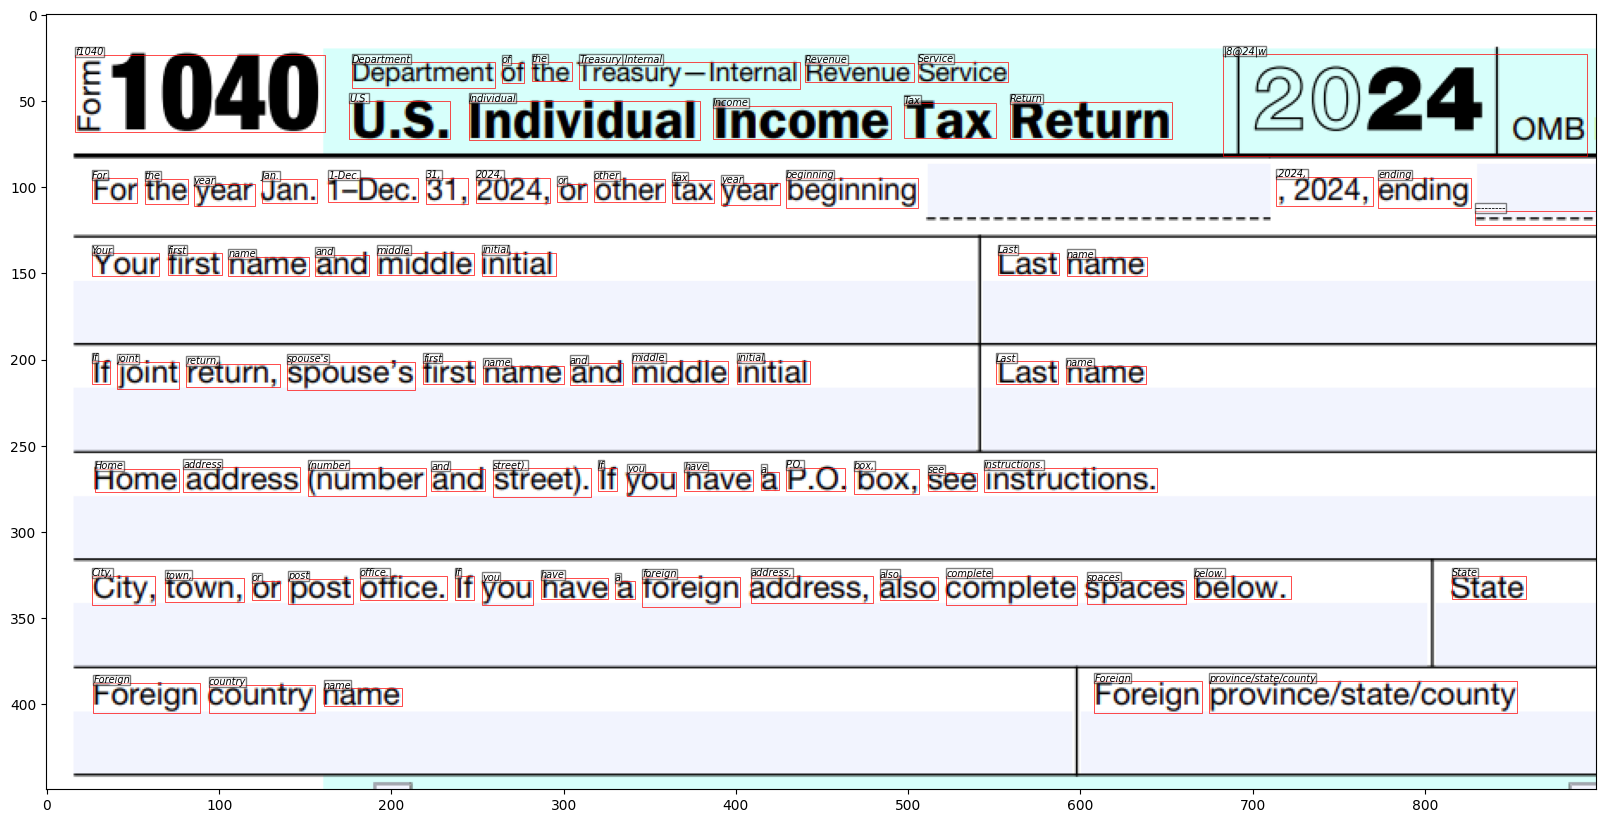

of the Treasury|lnternal Revenue Service	Department f1040 U.S. Individual Income Tax Return |8@24|w
For the year Jan. 1-Dec. 31, 2024, or other tax year beginning	,2024, ending
---------
Your first name and middle initial	Last name
If joint return, spouse's first name and middle initial	Last name
Home address (number and street). If you have a P.O. box, see instructions.
City, town, or post office. If you have a foreign address, also complete spaces below.	State
Foreign country name	Foreign province/state/county
> word prediction time: 12.17 [sec]
> character prediction time: 1.55 [sec]


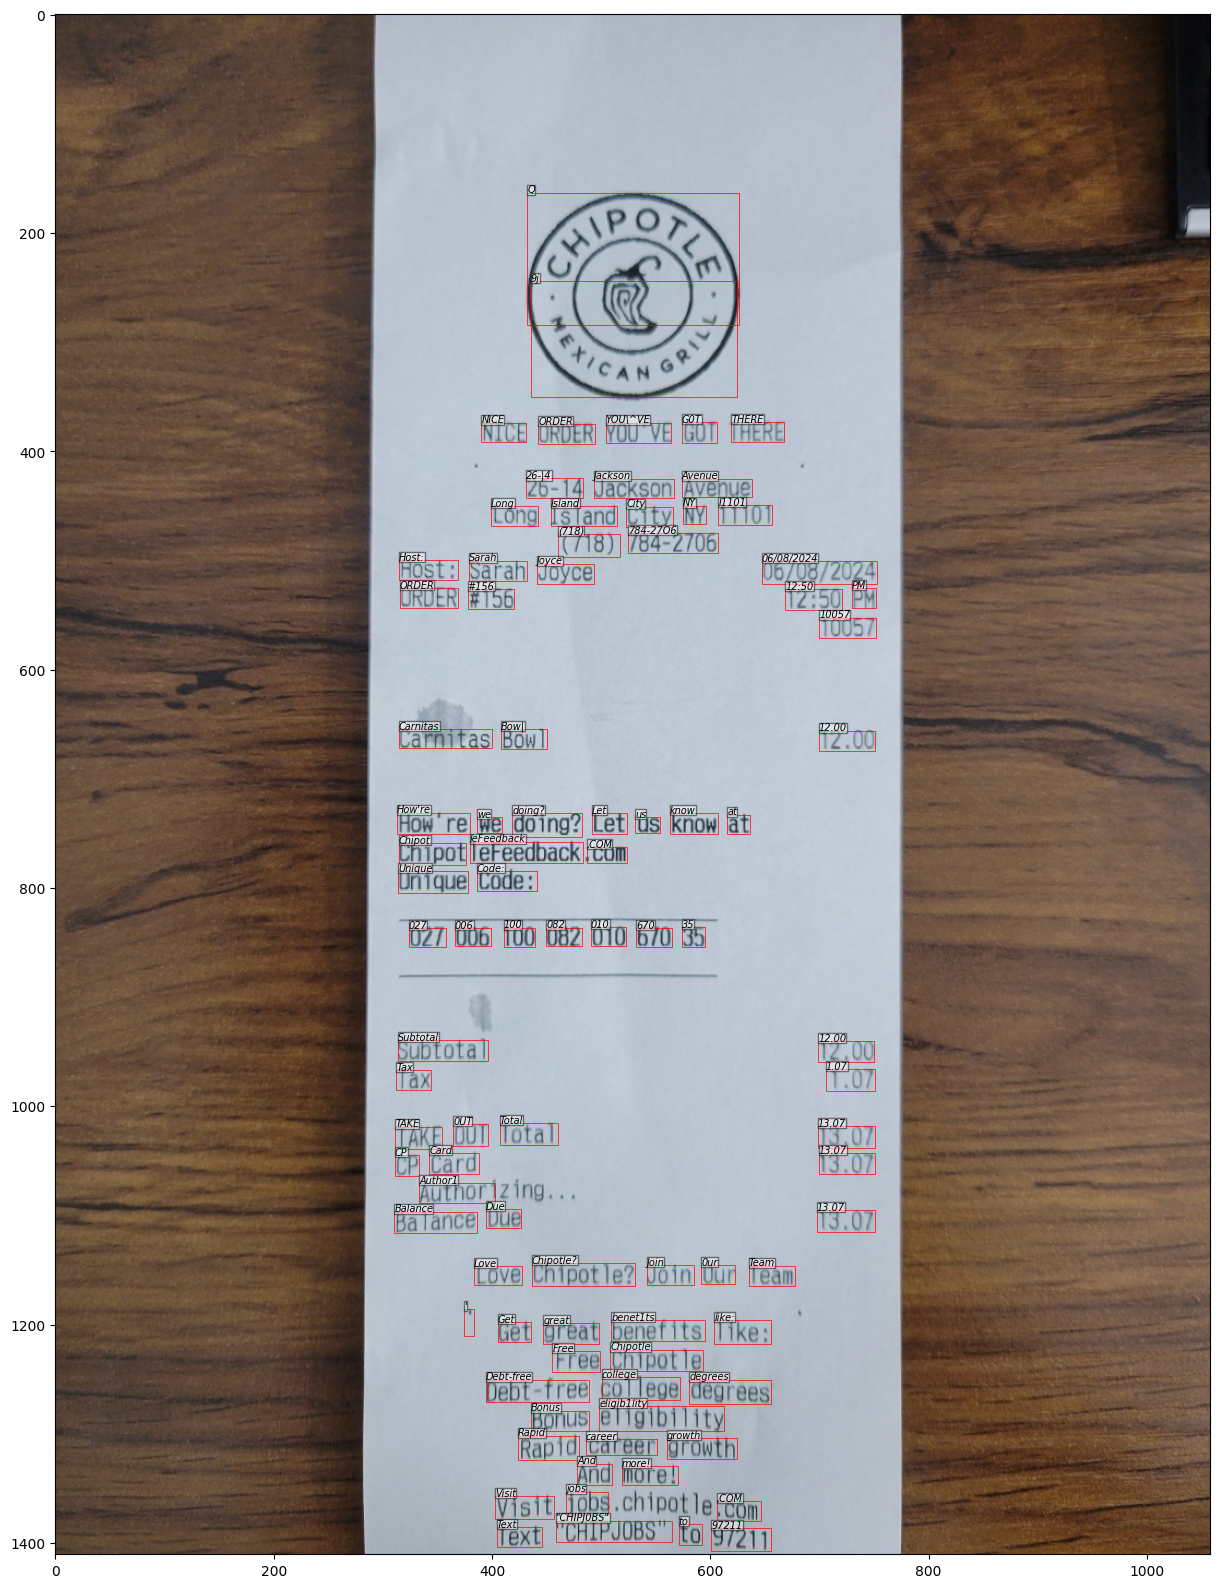

Q 9j
NICE ORDER YOU^VE G0T THERE
26-|4 Jackson Avenue
Long Island City NY I1101
(718) 784-27O6
Host: Sarah Joyce	06/08/2024
ORDER #156	12:50 PM
10057
Carnitas Bow|	12.00
How're we doing? Let us know at
Chipot leFeedback ,COM
Unique Code:
027 006 100 082 010 670 35
Subtotal	12.00
Tax	1.07
TAKE 0UT Total	13.07
CP Card	13.07
Author1
Balance Due	13.07
Love Chipotle? Join 0ur Team
'	Get great benet1ts like:
Free Chipotle
Debt-free college degrees
Bonus eligib1lity
Rapid career growth
And more!
Visit jobs	,COM
Text "CHIPJ0BS" to 97211


In [5]:
for filepath in [
    r'images/pic05.png',
    r'images/1040.png',
    # r'images/1040_full.png',
    r'images/chipotle.jpg',
]:
    #--- load image ---------------------------------------------------
    if re.search('\.(jpg|png)$', filepath, re.IGNORECASE): # load image file
        image = Image.open(filepath)
        if image.mode != 'RGB':
            image = image.convert("RGB")
        img = np.array(image)
    elif re.search('\.pdf$', filepath, re.IGNORECASE): # load pdf file
        doc = fitz.open(os.path.join(filepath)) # Open the PDF document
        page = doc[0] # Get the first page
        # pix = page.get_pixmap(dpi=300) # Get the pixmap of the page
        pix = page.get_pixmap(dpi=150) # Get the pixmap of the page
        img_bytes = pix.tobytes() # Convert the pixmap to bytes
        img = np.array(Image.open(io.BytesIO(img_bytes))) # Open the image using PIL
    else:
        raise(Exception(f'Brad error: unknown file extension...'))

    #--- predict -----------------------------------------------------
    # out = {'pred_texts': [('PERMANENT', (95, 610, 187, 623)),.......
    # out = ocr_model.predict(img, fix_img_H=100, debug=False) # BradOCR
    # out = ocr_model.predict(img, conf_thres=0.5, iou_thres=0.5, max_wh=0, verbose=True, draw_bboxes=False) # BradOCRv2
    out = ocr_model.predict(img, conf_thres=0.05, iou_thres=0.25, max_wh=0, verbose=True, draw_bboxes=False) # BradOCRv2

    #--- post-process ------------------------------------------------
    list_text_xyxy = out['pred_texts']
    i_to_line_map, seqs, uid_to_word_map = group_text_into_line(list_text_xyxy, alpha=1.0, debug=False)
    passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter='\t')
    # passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter=';')

    #--- plot bounding box -------------------------------------------
    plot_text_xyxy(img, out['pred_texts'])
    # plot_text_xyxy(img, i_to_line_map.values())
    # plot_text_xyxy(img, passage)

    print('\n'.join(p[0] for p in passage)) # text extracted
